In [1]:
#Load packages
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd 
import torch.nn.functional as F

## Load data

In [2]:
#Import data 
train_data_without = pd.read_csv('../Data/training.csv')
test_data = pd.read_csv('../Data/test.csv')
id_lookup_data = pd.read_csv('../Data/IdLookupTable.csv')
train_data = pd.read_csv('../Data/training_with_aug.csv')

In [3]:
#Delete unused axis
train_data = train_data.drop('Unnamed: 0', axis = 1)

In [4]:
#shuffle data
train_data = train_data.sample(n = len(train_data))

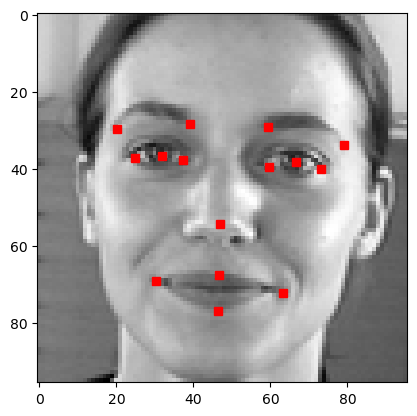

In [6]:
#Helper functions found from: https://www.kaggle.com/code/james146/facial-keypoints-detection-pytorch 
def get_image_and_keypoints(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(series).drop(['Image'], axis=0).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints(series)


def show_image_with_keypoints(series):
    image, keypoints = get_image_and_keypoints(series)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints(series)
    
show_image_with_keypoints_by_id(train_data, 4)

## Data preprocessing

In [7]:
#Shuffels dataset
train_data = train_data.sample(n = len(train_data))

In [8]:
#Split training and validation
data = train_data[:4020]
valid = train_data[4020:]


## Model

In [9]:
#Convert dataset for training

class imageDataset(Dataset):
    def __init__(self, file_name):
        labels=[file_name.iloc[i].values[0:30] for i in range(len(file_name))]
        inputs=[file_name.iloc[i].values[30:31] for i in range(len(file_name))]

        inputs = [(i[0].split()) for i in inputs]
        inputs = [[int(i) for i in j] for j in inputs] 
        inputs = [np.reshape(i, (96,96)) for i in inputs]
        inputs = [np.expand_dims(i,0) for i in inputs]

        self.labels=torch.tensor(labels,dtype=torch.float32) 
        self.inputs=torch.tensor(inputs, dtype=torch.float) 
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [10]:
#Define dataset 
data = imageDataset(data)
val = imageDataset(valid)

/Users/laurabraadrasmussen/opt/anaconda3/envs/slml/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_croot-udngs7fm/pytorch_1648016055234/work/torch/csrc/utils/tensor_new.cpp:201.)
  del sys.path[0]


In [11]:
#Define training data as tensor dataset 
batch_size = 64

x_train = data.inputs
y_train = data.labels

trainset = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

In [12]:
#Define validation data as tensor dataset 
x_val = val.inputs
y_val = val.labels

valset = torch.utils.data.TensorDataset(x_val, y_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)

### Network Architecture 

In [13]:
#Makeing network with inspiration from: https://www.kaggle.com/code/balon94/facial-keypoint-detection-5th-public-4th-private
num_classes = 30

#Define network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.relu
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, padding='same')
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=16,kernel_size=3,padding='same')
        self.bn1 = nn.BatchNorm2d(16)
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3)
        self.bn2 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=256,kernel_size=5)
        self.bn3 = nn.BatchNorm2d(256)
        
        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=1024,kernel_size=3)
        self.bn4 = nn.BatchNorm2d(1024)
        
        self.FC1 = nn.Linear(9216, 1024)
        self.FC2 = nn.Linear(1024, 256)  
        self.FC3 = nn.Linear(256, num_classes)  
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.bn1(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn2(x)
        x = F.max_pool2d(x, kernel_size=2)
        
        x = self.conv5(x)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn3(x)
        x = F.max_pool2d(x, kernel_size=2)
    
        x = self.conv7(x)
        x = F.relu(x)
        x = self.conv8(x)
        x = F.relu(x)
        x = self.bn4(x)
        
        x = x.view(x.shape[0],-1)
        
        x = self.FC1(x)

        x = self.FC2(x)
        x = self.FC3(x)
        
        return x

net = NeuralNetwork()

In [14]:
#When using pretrained model
model = torch.load('Newer_version.pt')

### Training the Network

In [14]:
#Define parameters 
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

nEpocs = 30 
totaliter = 0
net.train()

loss_plot = []
val_plot = []
min_valid_loss = np.inf

for epoch in range(nEpocs):  #Loop over the dataset multiple times
    running_loss = 0.0
    
    for i, data in enumerate(trainloader, 0):
        totaliter+=1
        
        #Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        #Zero the parameter gradients
        optimizer.zero_grad()

        #Forward + backward + optimize      
        outputs = net(inputs)
        outputs_reshape = outputs.view(outputs.shape[0],-1)
        loss = criterion(outputs_reshape, labels)
        loss.backward()
        optimizer.step()

        #Print Loss
        running_loss += loss.item()
        
    valid_loss = 0.0
    
    
    for data, labels in valloader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = net(data)
        target_reshape = target.view(target.shape[0],-1)
        loss = criterion(target_reshape,labels)
        valid_loss += loss.item() 


    
    loss_plot.append(running_loss / len(trainloader))
    val_plot.append(valid_loss / len(valloader))
    print('Epoch %d, Train loss: %.3f, Validation loss: %.3f' %(epoch + 1, running_loss / len(trainloader), valid_loss/len(valloader)))
    if min_valid_loss > valid_loss:
        print(f'Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(net.state_dict(), 'saved_model.pth')
        
print('Finished Training')
net.eval()

Epoch 1, Train loss: 255.374, Validation loss: 98.747
Saving The Model
Epoch 2, Train loss: 88.746, Validation loss: 68.746
Saving The Model
Epoch 3, Train loss: 58.668, Validation loss: 53.773
Saving The Model
Epoch 4, Train loss: 42.816, Validation loss: 40.473
Saving The Model
Epoch 5, Train loss: 36.208, Validation loss: 36.700
Saving The Model
Epoch 6, Train loss: 30.169, Validation loss: 35.018
Saving The Model
Epoch 7, Train loss: 26.757, Validation loss: 37.901
Epoch 8, Train loss: 21.617, Validation loss: 42.044
Epoch 9, Train loss: 20.783, Validation loss: 34.243
Saving The Model
Epoch 10, Train loss: 15.373, Validation loss: 30.511
Saving The Model
Epoch 11, Train loss: 16.962, Validation loss: 35.262
Epoch 12, Train loss: 10.871, Validation loss: 29.413
Saving The Model
Epoch 13, Train loss: 10.647, Validation loss: 35.274
Epoch 14, Train loss: 8.551, Validation loss: 26.595
Saving The Model
Epoch 15, Train loss: 8.950, Validation loss: 27.368
Epoch 16, Train loss: 7.462, V

NeuralNetwork(
  (conv1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (conv2): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (conv6): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv7): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (FC1): Linear(in_features=9216, out_features=1024, bias=True)
  (FC2): Linear(in_features=1024, out_fea

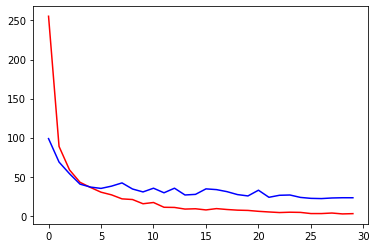

In [15]:
plt.plot(np.array(loss_plot), 'r')
plt.plot(np.array(val_plot), 'b')
plt.show()

In [16]:
#torch.save(net,'Newer_version.pt')

## Predictions on Testset

In [15]:
#Preparing testdata for predictions 
image_lists = [np.array(list((map(float, test_data.iloc[i, -1].split(' '))))).reshape(96, 96) for i in range(len(test_data))]

In [16]:
#When using pretrained model
test_images = [np.expand_dims(i,0) for i in image_lists]
test_outputs = [model(torch.Tensor(test_images[i]).unsqueeze(0)) for i in range(len(test_data))]

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


In [ ]:
#Network on testdata
test_images = [np.expand_dims(i,0) for i in image_lists]
test_outputs = [net(torch.Tensor(test_images[i]).unsqueeze(0)) for i in range(len(test_data))]

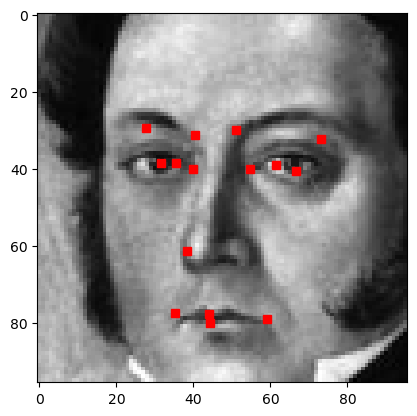

In [19]:
#See predictions of testdata 
def get_image_and_keypoints2(series,id):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = pd.DataFrame(test_outputs[id].tolist()).values.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    return get_image_and_keypoints2(series,id)


def show_image_with_keypoints2(series,id):
    image, keypoints = get_image_and_keypoints2(series,id)
    plt.imshow(image, cmap='gray')
    plt.plot(keypoints[:, 0], keypoints[:, 1], 'rs')


def show_image_with_keypoints_by_id2(test_data, id):
    series = test_data.iloc[id]
    show_image_with_keypoints2(series,id)
    
show_image_with_keypoints_by_id2(test_data, 400)

### Apply filter 

In [20]:
import cv2

In [21]:
#Changed plots
def get_image_and_keypoints1(series):
    image = series['Image']
    image = np.fromstring(image, sep=' ').reshape([96, 96]) / 255.0
    keypoints = test_outputs.reshape([15, 2])
    return image, keypoints

def get_image_and_keypoints_by_id1(train_data, id):
    series = train_data.iloc[id]
    return get_image_and_keypoints1(series)

def show_image_with_keypoints_by_id1(train_data, id):
    series = train_data.iloc[id]
    show_image_with_keypoints1(series)  

def show_image_with_keypoints1(series):
    image, keypoints = get_image_and_keypoints1(series)
    plt.imshow(image, cmap='gray')

In [23]:
# Prepare variables for the filter

#keypoints = y_train[0] (fra Filter.ipynb)
keypoints = test_outputs[1][0].tolist()
#keypoints = keypoints[0]

#img_copy = np.array(x_train[0]) (fra Filter.ipynb)
img_copy = np.array(test_images[0])

img_copy = np.reshape(img_copy, (96,96,1)) #(fra Filter.ipynb)

x_coords = keypoints[0::2]     
y_coords = keypoints[1::2]   

In [24]:
# Convert from grayscale to BGRA.

img_copy = np.float32(img_copy)
img_copy = np.array(img_copy)

img_copy = cv2.cvtColor(img_copy, cv2.COLOR_GRAY2BGRA)

In [25]:
# Points used for placing the filters.
x_coords = list(x_coords)
left_brow_coords = (int(x_coords[7]), int(y_coords[7]))
right_brow_coords = (int(x_coords[9]), int(y_coords[9]))
nose_coords = (int(x_coords[10]), int(x_coords[10]))

In [26]:
# Apply the nose filter
nose_width = 10

nose_filter = cv2.imread('nose.png', -1)
nose_filter = cv2.resize(nose_filter, (nose_width*2,20))
sw,sh,sc = nose_filter.shape


for i in range(0,sw):
    for j in range(0,sh):
        if nose_filter[i,j][3] != 0:
            img_copy[nose_coords[0]+i-8, nose_coords[1]+j-8] = nose_filter[i,j]

In [27]:
# Apply Antlers filter on the image.
antlers_width = left_brow_coords[0] - right_brow_coords[0]

antlers_filter = cv2.imread('antlers.png', -1)
antlers_filter = cv2.resize(antlers_filter, (antlers_width,35))
gw,gh,gc = antlers_filter.shape

for i in range(0,gw):
    for j in range(0,gh):
        if antlers_filter[i,j][3] != 0:
            img_copy[left_brow_coords[1]+i-28, right_brow_coords[0]+j] = antlers_filter[i,j]

In [28]:
img_copy = img_copy.astype(np.uint8)
img_copy = cv2.cvtColor(img_copy, cv2.COLOR_BGRA2RGB)       # Revert back to RGB

In [29]:
def plot_sample1(image):
    image = image.reshape(96,96,3)
    fig, axis = plt.subplots()
    axis.imshow(image)
    plt.imshow((image).astype(np.uint8))

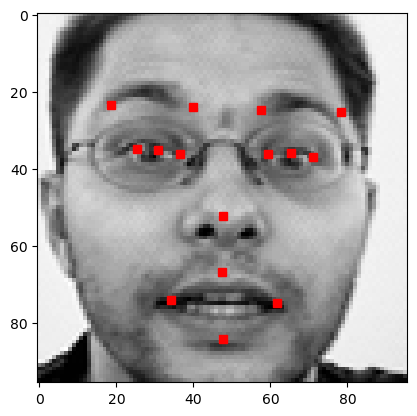

In [30]:
show_image_with_keypoints_by_id2(test_data, 0)

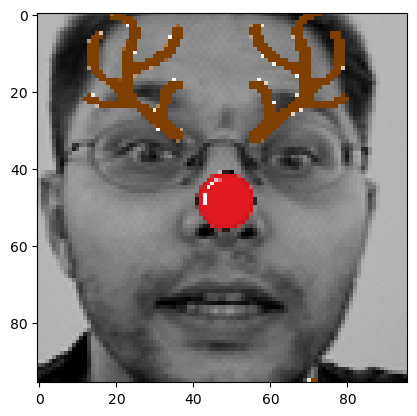

In [31]:
plot_sample1(img_copy)